# ChainerでMNIST手書き文字の認識

参考: 
- http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412
- https://github.com/tok41/sample_neural_network
- https://github.com/matsuken92/Qiita_Contents/blob/master/chainer-MNIST/chainer-MNIST_forPubs.ipynb

概要:
* 「モデル学習」用のアプリ。学習済みのモデルを使って「文字認識」するアプリの２段構成
* このipythonでは、「モデル学習」の部分だけ

### モデルの定義
* Prepare multi-layer perceptron model
* **3層パーセプトロンモデル**を作る
* 入力(l1)：28×28の画像なので784次元
* 出力(l3)：数字なので10次元

In [40]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six
import pickle

from sklearn.datasets import fetch_mldata
from chainer import computational_graph as c
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F

import data
import argparse

plt.style.use('ggplot')

### パラメータの設定

In [2]:
batchsize = 100        # 確率的勾配降下法で学習させる際の１回分のバッチサイズ
n_epoch   = 20          # 学習の繰り返し回数
n_units   = 1000        # 中間層の次元数

### 手書き数字データのダウンロード
* data パッケージを使ってデータを取得する
* 実行ディレクトリ上に、以下ファイルができる
 * train-labels-idx1-ubyte.gz
 * train-images-idx3-ubyte.gz
 * t10k-images-idx3-ubyte.gz
 * t10k-labels-idx1-ubyte.gz
 * mnist.pkl
* 結構時間がかかる

* DLしてきたデータは、28*28ピクセル(784次元のベクトル)の画像データの濃淡を0~1で表現

    (len(mnist['data'][0]) = 784)

In [3]:
print('load MNIST dataset')                                                # MNISTの手書き数字データ
mnist = data.load_mnist_data()
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255                                                          # 0-1に変換
mnist['target'] = mnist['target'].astype(np.int32)

load MNIST dataset
Done
Done
Done
Done
Converting training data...
Done
Converting test data...
Done
Save output...
Done
Convert completed


### 手書きデータの描画

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


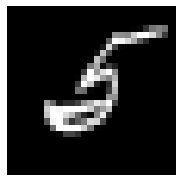

In [5]:
def draw_digit(data):
    plt.figure(figsize=(3, 3))
    size = 28
    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]                              # flip vertical
    plt.xlim(0,27); plt.ylim(0,27);
    plt.pcolor(X, Y, Z); plt.gray();
    plt.tick_params(labelbottom="off"); plt.tick_params(labelleft="off");
    plt.show()

draw_digit(mnist['data'][1111])

## 学習過程
### (前処理) 学習用と評価用にデータを分ける

   - code
    * np.split http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.split.html

In [7]:
N = 60000                                                                       # 学習用 N個、検証用 残りの個数
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

### モデルの定義
* Prepare multi-layer perceptron model
* **3層パーセプトロンモデル**を作る
* 入力(l1)：28×28の画像なので784次元
* 出力(l3)：数字なので10次元

In [8]:
model = chainer.FunctionSet(
    l1=F.Linear(784, n_units),
    l2=F.Linear(n_units, n_units),
    l3=F.Linear(n_units, 10))

### 順伝播の構造定義
  - code
    * chainer.Variable= データは配列からChainerのVariableという型（クラス）のオブジェクトに変換
    * F.relu(): 正規化線形関数(Rectified Linear Unit function)
    * F.dropout: http://docs.chainer.org/en/stable/reference/functions.html#noise-injections
     * dropout(x, ratio=0.5, train=True)
     * x: input
     * ratio: 0を出力する確率
     * train: Falseの場合はxをそのまま返却する
     * return: ratioの確率で0を、1−ratioの確率で,x*(1/(1-ratio))の値を返す


In [9]:
def forward(x_data, y_data, train=True):                                           # Neural net architecture
    x, t = chainer.Variable(x_data), chainer.Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y = model.l3(h2)
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)               # 多クラス分類 = cross entropy

### Optimizerの設定
  * using Adam
    * Here is in detail. http://ja.scribd.com/doc/260859670/30minutes-Adam

In [10]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

### 学習の実行
* GPGPU無しでけっこう時間かかる

In [16]:
train_loss = []; train_acc  = []; test_loss = []; test_acc  = [];
l1_W = []; l2_W = []; l3_W = [];

# Learning loop
for epoch in xrange(1, n_epoch+1):
    print 'epoch', epoch
    ## Randomizing training data
    perm = np.random.permutation(N)

    # TRAINING
    sum_accuracy = 0; sum_loss = 0;
    for i in xrange(0, N, batchsize):
        x_batch = x_train[perm[i:i+batchsize]]; y_batch = y_train[perm[i:i+batchsize]]
        optimizer.zero_grads()                                                                      # Initializing gradients
        loss, acc = forward(x_batch, y_batch)                                            # calc loss and accuracy
        loss.backward(); optimizer.update();                                               # calc grad by backprop
        train_loss.append(loss.data); train_acc.append(acc.data);          # accumurate loss and accuracy
        sum_loss += float((loss.data)) * batchsize; sum_accuracy += float((acc.data)) * batchsize;
    print 'train mean loss={}, accuracy={}'.format(sum_loss/N, sum_accuracy/N)

    # TEST > Generalization performance
    sum_accuracy = 0; sum_loss = 0;
    for i in xrange(0, N_test, batchsize):
        x_batch = x_test[i:i+batchsize]; y_batch = y_test[i:i+batchsize];
        loss, acc = forward(x_batch, y_batch, train=False)                        # calc loss and accuracy
        test_loss.append(loss.data); test_acc.append(acc.data);            # accumurate loss and accuracy
        sum_loss     += float((loss.data)) * batchsize; sum_accuracy += float((acc.data)) * batchsize;
    print 'test  mean loss={}, accuracy={}'.format(sum_loss/N_test, sum_accuracy/N_test)
    l1_W.append(model.l1.W); l2_W.append(model.l2.W); l3_W.append(model.l3.W); # save params
print("Finish : Training Process")

epoch 1
train mean loss=4763.93785299, accuracy=0.825599998633
test  mean loss=2478.18882492, accuracy=0.907200000882
epoch 2
train mean loss=5178.69049601, accuracy=0.829366664886
test  mean loss=2511.89378239, accuracy=0.917700004578
epoch 3
train mean loss=5977.57268016, accuracy=0.82636666437
test  mean loss=2140.18440981, accuracy=0.931300002337
epoch 4
train mean loss=6115.79678507, accuracy=0.832633332511
test  mean loss=4912.08418106, accuracy=0.875800002813
epoch 5
train mean loss=7059.23035624, accuracy=0.828099997441
test  mean loss=3931.09659042, accuracy=0.904200001359
epoch 6
train mean loss=7487.90935282, accuracy=0.831516665816
test  mean loss=3948.57380219, accuracy=0.89150000155
epoch 7
train mean loss=7840.72346619, accuracy=0.834049999019
test  mean loss=3371.33609827, accuracy=0.924000002742
epoch 8
train mean loss=8651.85318685, accuracy=0.832599998415
test  mean loss=3026.90962322, accuracy=0.931900006533
epoch 9
train mean loss=9091.4997054, accuracy=0.836983331

## 学習結果、学習過程を確認
### 訓練の過程での精度変化をみる

[]

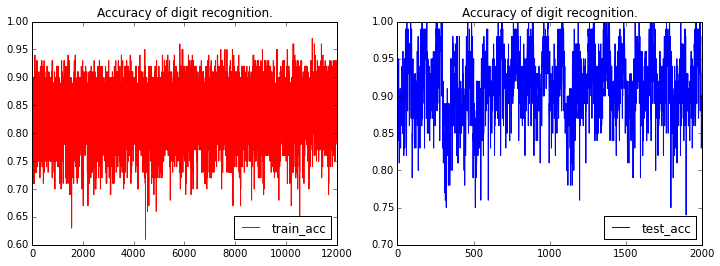

In [17]:
# plot accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(len(train_acc)), train_acc, color="#FF0000")
plt.legend(["train_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.subplot(1,2,2)
plt.plot(range(len(test_acc)), test_acc, color="#0000FF")
plt.legend(["test_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.plot()

### 学習結果の確認 : NNの第１層のパラメータを見てみる
* NNの各ノードがどのような特徴に反応するのかを見てみる
* 入力層は784次元（28×28ピクセル）、それを第１層のノード(1000)に入力する(モデルの定義により)
* 1000ノードのうち、ランダムに100ノードのパラメータを可視化
* 出力結果を眺めると、直線に反応するノードとか、丸に反応するノードとかが見えてきて面白い

<function matplotlib.pyplot.show>

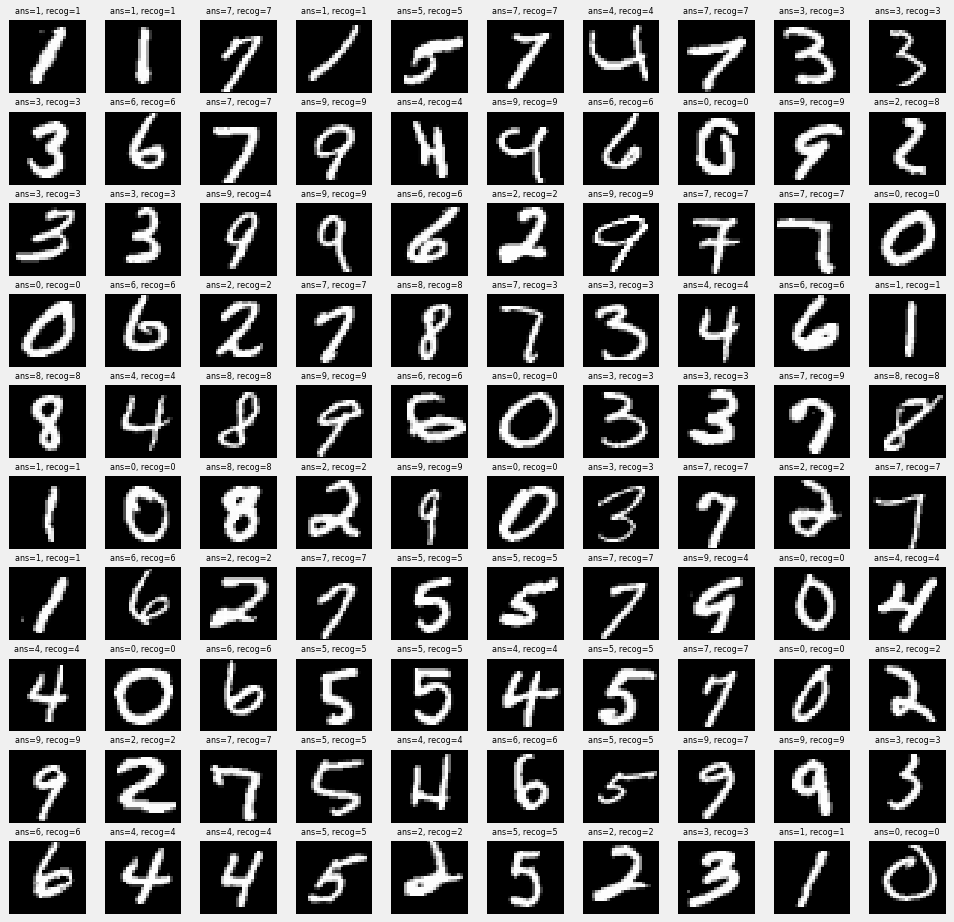

In [19]:
# Show Predict Result
plt.style.use('fivethirtyeight')
def draw_digit3(data, n, ans, recog):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27); plt.ylim(0,27);
    plt.pcolor(Z)
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off"); plt.tick_params(labelleft="off");

plt.figure(figsize=(15,15))
cnt = 0
for idx in np.random.permutation(N)[:100]:
    # Forwarding for prediction
    xxx = x_train[idx].astype(np.float32)
    h1 = F.dropout(F.relu(model.l1(Variable(xxx.reshape(1,784)))),  train=False)
    h2 = F.dropout(F.relu(model.l2(h1)), train=False)
    y  = model.l3(h2)
    cnt+=1
    draw_digit3(x_train[idx], cnt, y_train[idx], np.argmax(y.data))
plt.show

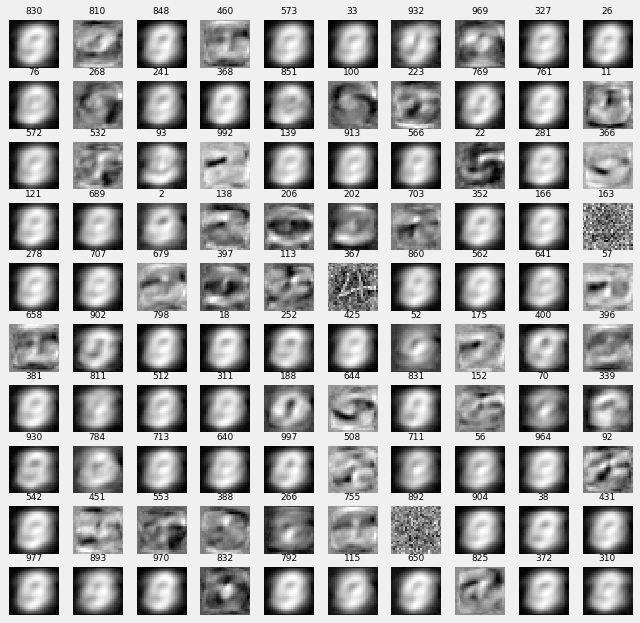

In [30]:
# layer 1
def draw_digit2(data, n, i):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1); plt.ylim(0,size-1)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off"); plt.tick_params(labelleft="off")

plt.figure(figsize=(10,10))
cnt = 1
for i in np.random.permutation(1000)[:100]:
    draw_digit2(l1_W[len(l1_W)-1].data[i], cnt, i)
    cnt += 1
plt.show()

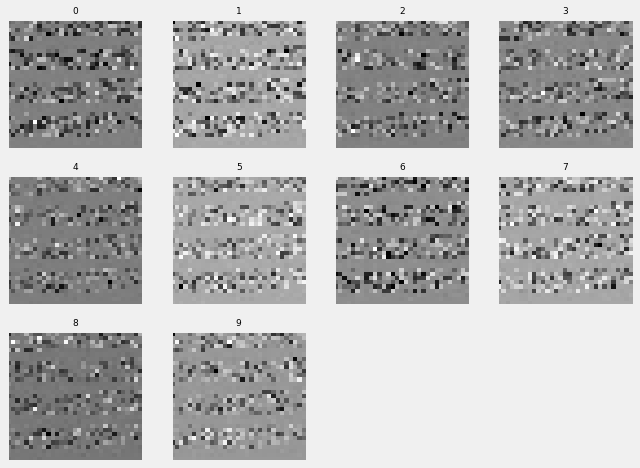

In [35]:
# layer 3
def draw_digit3(data, n, i):
    size = 32
    plt.subplot(4, 4, n)
    data = np.r_[data,np.zeros(24)]
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1); plt.ylim(0,size-1);
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off"); plt.tick_params(labelleft="off");

plt.figure(figsize=(10,10))
cnt = 1
for i in range(10):
    draw_digit3(l3_W[len(l3_W)-1].data[i], cnt, i)
    cnt += 1
plt.show()

### モデルのダンプ
* 学習済みのモデルを別のアプリで利用するために、モデルをファイルにダンプする
* モデルはpickleパッケージを使ってダンプする
 * GPU使って学習した場合、グラボのメモリにデータを展開するので注意
 * GPUで学習したモデルをCPUのみのマシンで動かす可能性がある場合には、事前にto_cpuコマンドでCPUに展開するように指定しおく必要がある
 
 ## pros
 * chainerでつくられるモデルは、pickleパッケージを使ってダンプできる
 * このダンプしてきたモデルを使って文字識別させる
 * 学習にはかなりの計算機コストがかかるが、学習済みモデルを使って判別させるだけなら、非力なマシンでも十分
 * スマホに搭載したりとかの応用も利く
 * *注意* GPUで学習したモデルを非GPU環境でそのまま適用できないので注意
 * 今回の例では非GPU環境で学習させたのでそのあたり気にしないでOK

In [41]:
fid = open('test.model', 'wb')
pickle.dump(model, fid)
fid.close()

# Draw activation functions

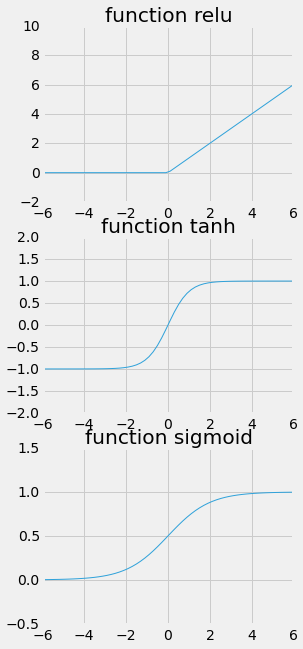

In [38]:
x_data = np.linspace(-10, 10, 100, dtype=np.float32)
x = Variable(x_data)

plt.figure(figsize=(4,10)); i=0;
for func, y_lim in zip([F.relu, F.tanh, F.sigmoid], [(-2,10),(-2,2),(-.5,1.5)]):
    y = func(x)
    plt.subplot(311+i); i += 1;
    plt.title(str(func).split('at')[0].replace('<',''))
    plt.ylim(y_lim);    plt.xlim(-6,6);
    plt.plot(x.data, y.data, lw=1)
plt.show()